
# 🌲 독성예측 — RandomForest **Bagging** + OOF 임계값 최적화 + 예측 (.ipynb)

- **데이터**: `train.csv` (SMILES 제외, 수치형 + ECFP/FCFP/PTFP)
- **모델**: RandomForest를 **seed bagging**(다른 random_state / 부트스트랩)으로 3~5개 학습 → 평균 확률
- **튜닝**: **GridSearch 재실행 없음**. 5-Fold OOF 확률로 **F1 최대 임계값**을 탐색
- **출력**: `predict_input.csv` → `predict_output.csv` (`SMILES`, `output`)
- **옵션**: 기존 학습 모델(`rf_best_gridsearch.joblib` 또는 `rf_no_pca.joblib`)이 있으면 **그 파라미터를 재사용**하여 배깅


In [1]:

# !pip install -q scikit-learn pandas numpy joblib matplotlib

import numpy as np, pandas as pd, matplotlib.pyplot as plt, joblib
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

TRAIN_CANDIDATES = ["/mnt/data/train.csv", "./train.csv", "/content/train.csv"]
PRED_CANDIDATES  = ["/mnt/data/predict_input.csv", "./predict_input.csv", "/content/predict_input.csv"]
MODEL_CANDIDATES = ["/mnt/data/rf_best_gridsearch.joblib", "./rf_best_gridsearch.joblib",
                    "/mnt/data/rf_no_pca.joblib", "./rf_no_pca.joblib", "/content/rf_no_pca.joblib"]

N_MODELS = 5  # 배깅 개수 (3~5 권장)


## 1) 데이터 로드 & 피처 구성 (SMILES 제외, No PCA)

In [2]:

# load train.csv
train_path = next((p for p in TRAIN_CANDIDATES if Path(p).exists()), None)
assert train_path, "train.csv 파일이 필요합니다."
df = pd.read_csv(train_path)
print(f"[train] {train_path}  shape={df.shape}")

# label clean
df['label_num'] = pd.to_numeric(df['label'], errors='coerce')
df = df[df['label_num'].isin([0,1])].copy()
y = df['label_num'].astype(int).to_numpy()

# features
exclude_cols = {'label','label_num','SMILES'}
base_feats = [c for c in ['MolWt','clogp','sa_score','qed'] if c in df.columns]
fp_cols = [c for c in df.columns if any(k in c.upper() for k in ['ECFP','FCFP','PTFP'])]
feature_cols = [c for c in (base_feats + fp_cols) if c not in exclude_cols]

X = df[feature_cols].replace([np.inf,-np.inf], np.nan).fillna(0).to_numpy()

print(f"Samples={X.shape[0]}, Features={X.shape[1]}  (base={len(base_feats)}, fp={len(fp_cols)})")
print("Label distribution:\n", pd.Series(y).value_counts().sort_index())


[train] ./train.csv  shape=(8349, 3078)
Samples=8349, Features=3076  (base=4, fp=3072)
Label distribution:
 0    3807
1    4542
Name: count, dtype: int64


## 2) 베이스 하이퍼파라미터 설정 (기존 모델 파라미터 재사용 우선)

In [3]:

# 기존 모델이 있으면 그 파라미터를 재사용 (GridSearch 재탐색 없음)
base_params = dict(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=RANDOM_STATE
)

model_path = next((p for p in MODEL_CANDIDATES if Path(p).exists()), None)
if model_path is not None:
    try:
        loaded = joblib.load(model_path)
        # 경우에 따라 파이프라인이 아닌 순수 RF일 것을 가정
        if isinstance(loaded, RandomForestClassifier):
            base_params.update({k: loaded.get_params().get(k, v) for k, v in base_params.items()})
            print(f"[model] Loaded base params from {model_path}")
        elif isinstance(loaded, dict) and 'models' in loaded:
            # 이미 배깅 저장 형태일 경우 첫 모델의 파라미터 참고
            if isinstance(loaded['models'][0], RandomForestClassifier):
                base_params.update({k: loaded['models'][0].get_params().get(k, v) for k, v in base_params.items()})
                print(f"[model] Loaded bagging params from {model_path}")
            else:
                print(f"[model] dict found but unknown model type; using default params.")
        else:
            print(f"[model] Not an RF instance; using default params.")
    except Exception as e:
        print(f"[WARN] Could not load params from {model_path}: {e} — using defaults.")
else:
    print("[model] No prior model found — using default params.")

print("Base RF params:", base_params)


[model] Loaded base params from ./rf_best_gridsearch.joblib
Base RF params: {'n_estimators': 400, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'n_jobs': -1, 'class_weight': 'balanced_subsample', 'random_state': 42}


## 3) 5-Fold OOF 기반 임계값 탐색 + 배깅 구성

[Fold 1] interim F1@0.5 = 0.8260
[Fold 2] interim F1@0.5 = 0.8123
[Fold 3] interim F1@0.5 = 0.7941
[Fold 4] interim F1@0.5 = 0.8189
[Fold 5] interim F1@0.5 = 0.8269
★ Best Threshold t* = 0.470 | OOF F1 = 0.8172


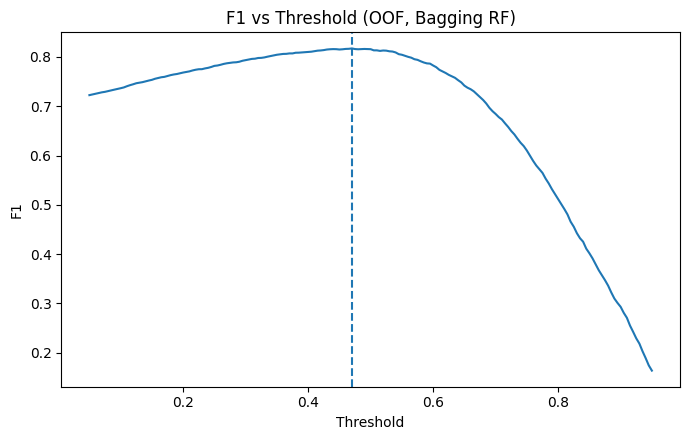

In [4]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof_proba = np.zeros(X.shape[0], dtype=float)

def fit_one_rf(seed, X_tr, y_tr):
    params = base_params.copy()
    params['random_state'] = seed
    clf = RandomForestClassifier(**params)
    # 부트스트랩 샘플로 배깅 효과 강화
    rng = np.random.RandomState(seed)
    boot_idx = rng.choice(len(X_tr), size=len(X_tr), replace=True)
    clf.fit(X_tr[boot_idx], y_tr[boot_idx])
    return clf

fold_models = []  # 각 폴드마다 학습된 배깅 모델 리스트 저장(임계값 탐색 후 폐기 가능)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, y_tr = X[tr_idx], y[tr_idx]
    X_va, y_va = X[va_idx], y[va_idx]

    models = []
    proba_sum = np.zeros(len(va_idx), dtype=float)
    for m in range(N_MODELS):
        seed = RANDOM_STATE + 1000*fold + m  # 폴드별로 다른 시드
        clf = fit_one_rf(seed, X_tr, y_tr)
        models.append(clf)
        proba_sum += clf.predict_proba(X_va)[:,1]
    fold_models.append(models)
    oof_proba[va_idx] = proba_sum / N_MODELS
    f1_fold = f1_score(y_va, (oof_proba[va_idx] >= 0.5).astype(int))
    print(f"[Fold {fold}] interim F1@0.5 = {f1_fold:.4f}")

# 임계값 스윕
ts = np.linspace(0.05, 0.95, 181)
f1s = np.array([f1_score(y, (oof_proba >= t).astype(int)) for t in ts])
best_idx = int(np.argmax(f1s))
best_t = float(ts[best_idx])
best_f1 = float(f1s[best_idx])
print(f"★ Best Threshold t* = {best_t:.3f} | OOF F1 = {best_f1:.4f}")

# 시각화
plt.figure(figsize=(7,4.5))
plt.plot(ts, f1s)
plt.axvline(best_t, linestyle='--')
plt.title("F1 vs Threshold (OOF, Bagging RF)")
plt.xlabel("Threshold"); plt.ylabel("F1")
plt.tight_layout(); plt.show()


## 4) 전체 데이터로 최종 배깅 모델 재학습 & 저장

In [5]:

final_models = []
for m in range(N_MODELS):
    seed = RANDOM_STATE + 777*m
    clf = fit_one_rf(seed, X, y)
    final_models.append(clf)

bundle = {
    "models": final_models,
    "feature_cols": feature_cols,
    "base_feats": base_feats,
    "fp_cols": fp_cols,
    "best_t": best_t,
    "params": base_params,
    "n_models": N_MODELS
}
joblib.dump(bundle, "rf_bagging_bundle.joblib")
print("✅ 저장 완료: rf_bagging_bundle.joblib")

# 참고용: 학습 데이터 평가 (threshold 적용)
proba_train = np.mean([m.predict_proba(X)[:,1] for m in final_models], axis=0)
pred_train = (proba_train >= best_t).astype(int)
print("\n[Training Data Evaluation]")
print(classification_report(y, pred_train, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y, pred_train))


✅ 저장 완료: rf_bagging_bundle.joblib

[Training Data Evaluation]
              precision    recall  f1-score   support

           0     0.9832    0.9511    0.9669      3807
           1     0.9601    0.9863    0.9731      4542

    accuracy                         0.9703      8349
   macro avg     0.9717    0.9687    0.9700      8349
weighted avg     0.9706    0.9703    0.9702      8349

Confusion Matrix:
[[3621  186]
 [  62 4480]]


## 5) predict_input.csv → predict_output.csv (SMILES, output)

In [6]:

pred_path = next((p for p in PRED_CANDIDATES if Path(p).exists()), None)
assert pred_path, "predict_input.csv 파일이 필요합니다."
pred_df = pd.read_csv(pred_path)
print(f"[predict_input] {pred_path}  shape={pred_df.shape}")

X_base_pred = pred_df[base_feats].replace([np.inf,-np.inf], np.nan).fillna(0) if base_feats else None
X_fp_pred = pred_df[fp_cols].replace([np.inf,-np.inf], np.nan).fillna(0) if fp_cols else None

if X_base_pred is not None and X_fp_pred is not None:
    X_pred = np.hstack([X_base_pred.values, X_fp_pred.values])
elif X_fp_pred is not None:
    X_pred = X_fp_pred.values
elif X_base_pred is not None:
    X_pred = X_base_pred.values
else:
    raise ValueError("예측에 사용할 피처가 없습니다.")

# 앙상블 확률 평균 → 임계값 적용
proba_pred = np.mean([m.predict_proba(X_pred)[:,1] for m in final_models], axis=0)
pred_label = (proba_pred >= best_t).astype(int)

out_df = pd.DataFrame({
    "SMILES": pred_df["SMILES"],
    "output": pred_label
})
out_df.to_csv("predict_output.csv", index=False)
print("✅ 예측 결과 저장 완료: predict_output.csv")
out_df.head()


[predict_input] ./predict_input.csv  shape=(927, 3077)
✅ 예측 결과 저장 완료: predict_output.csv


,SMILES,output
0,OC(=O)c1cc2sccc2[nH]1,1
1,[O-][n+]1onc(c2ccccc2)c1C#N,1
2,CN1C(=O)N(C)c2ncn(C)c2C1=O,1
3,Clc1cccc(c1)C2CNCC=CC2,1
4,CCN(CC)CC(=O)Nc1c(C)cccc1C,1


In [7]:
# ================================================
# 🧪 Bagging OOF 재평가 (F1 @ 0.5 와 F1 @ best_t)
# 전제: X, y, base_params, N_MODELS, RANDOM_STATE 가 위에서 정의되어 있어야 함
# ================================================
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

def fit_one_rf(seed, X_tr, y_tr, base_params):
    params = base_params.copy()
    params['random_state'] = seed
    clf = RandomForestClassifier(**params)
    rng = np.random.RandomState(seed)
    boot_idx = rng.choice(len(X_tr), size=len(X_tr), replace=True)  # 간단 배깅
    clf.fit(X_tr[boot_idx], y_tr[boot_idx])
    return clf

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof_proba = np.zeros(X.shape[0], dtype=float)

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, y_tr = X[tr_idx], y[tr_idx]
    X_va, y_va = X[va_idx], y[va_idx]

    proba_sum = np.zeros(len(va_idx), dtype=float)
    for m in range(N_MODELS):
        seed = RANDOM_STATE + 1000*fold + m
        clf = fit_one_rf(seed, X_tr, y_tr, base_params)
        proba_sum += clf.predict_proba(X_va)[:, 1]
    oof_proba[va_idx] = proba_sum / N_MODELS

# F1 @ 0.5
f1_05 = f1_score(y, (oof_proba >= 0.5).astype(int))
# F1 @ best_t (위 임계값 튜닝에서 얻은 best_t 변수를 재사용)
try:
    f1_best = f1_score(y, (oof_proba >= best_t).astype(int))
except NameError:
    # best_t가 없다면 OOF에서 다시 스윕해서 구함
    ts = np.linspace(0.05, 0.95, 181)
    f1s = np.array([f1_score(y, (oof_proba >= t).astype(int)) for t in ts])
    best_t = float(ts[int(np.argmax(f1s))])
    f1_best = f1s.max()

print(f"OOF F1 @ 0.5  = {f1_05:.4f}")
print(f"OOF F1 @ t*({best_t:.3f}) = {f1_best:.4f}")


OOF F1 @ 0.5  = 0.8157
OOF F1 @ t*(0.470) = 0.8172
